In [1]:
gene_familly = None

In [2]:
# Parameters
gene_familly = "BES1"


<div style="hwidth: 100%; background-color: #ddd; overflow:hidden; ">
    <div style="display: flex; justify-content: center; align-items: center; border-bottom: 10px solid #80c4e7; padding: 3px;">
        <h2 style="position: relative; top: 3px; left: 8px;">S2 Project: DNA Classification - (part2: Approach 2)</h2>
        <!--<img style="position: absolute; height: 68px; top: -2px;; right: 18px" src="./Content/Notebook-images/dna1.png"/>-->
    </div>
    <div style="padding: 3px 8px;">
        
1. <strong>Description</strong>:
   - In this approach, we represent DNA sequences using k-mer frequencies. Each sequence is encoded as a vector where each element represents the frequency of a specific k-mer in the sequence. This vector representation is then used as input to a neural network architecture for classification.

2. <strong>Pros</strong>:
   - Utilizes frequency analysis: By representing sequences based on the frequency of k-mers, the model can capture important patterns and motifs in the DNA sequences.
   - Flexible architecture: Neural networks provide a flexible framework for learning complex relationships between features, allowing the model to adapt to different types of data.

3. <strong>Cons</strong>:
   - Curse of dimensionality: Depending on the value of k and the size of the alphabet (e.g., DNA bases A, C, G, T), the feature space can become very large, leading to increased computational complexity and potential overfitting.
   - Loss of sequence information: By focusing solely on k-mer frequencies, the model may overlook important sequential dependencies and structural information present in the DNA sequences.
    </div>    
</div>

### 1 - Importing utils
The following code cells will import necessary libraries.

In [3]:
import os, random, string, itertools, warnings, sys, json
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score, 
    f1_score, 
    recall_score, 
    precision_score
)

from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction import DictVectorizer
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.layers import LSTM, SimpleRNN
from keras.layers import Flatten, Embedding, BatchNormalization, Dropout, MaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import sequence
from keras.layers import Conv1D

# OS
current_directory = os.getcwd()
root_directory = os.path.abspath(os.path.join(current_directory, os.pardir))
utils_directory = os.path.join(root_directory, 'processing')
sys.path.append(utils_directory)

# Import Utils
import fasta
from representation import DNA
from visualization import VISU, VISUReport

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


### 2 - Importing Dataset
The following function will read our preprocessed **.csv file** and return a pandas dataframe

In [5]:
# READ GENE_INFO JSON FILE

gene_info_path = "../data/gene_info.json"
dataset_path   = "../data/one_vs_other/"
with open(gene_info_path, 'r') as json_file:
    gene_info = json.load(json_file)

In [6]:
# FOCUS ON GENE FAMALLY

gene_dict = gene_info[gene_familly]
df_path = dataset_path+gene_dict['file_code']+".csv"

In [7]:
USE_FULL_DF = True

if USE_FULL_DF:
    dataset = pd.read_csv(df_path)
else:
    dataset_ = pd.read_csv(df_path)
    r = min(5000/len(dataset_), 1)
    _, dataset = train_test_split(dataset_, test_size=r, stratify=dataset_['class'], random_state=42)
dataset.head()

,id,sequence,length,class
0,Achn025631,MMSFYLSSVKDNQRYYVEREKGCKPTLAEIGGTSTNITPCSSQNPS...,248,1
1,Achn038411,MTSLSVSQSRVRPPPVVPIGGLRSSKTTNRFHERFPDSLLNFEINE...,355,1
2,Achn072001,MTTEMQRFGTSEEDDEDMGMDVKEEDDDDDDDDDEKNNGTPIMVGV...,744,1
3,Achn103731,MASGTRLPSWKERENNKRRERRRRAIAAKIYTGLRMYGNYKLPKHC...,345,1
4,Achn131841,MWEGESDAAATTGGGGRRKPSWRERENNRRRERRRRAVAAKIYSGL...,310,1


In [8]:
report = VISUReport(gene_familly, dataset)

* **Model Utils**

In [9]:
domaine = "ACDEFGHIKLMNPQRSTVWYX"
def model_checkpoint(model_name):
    gene_familly_ = gene_familly.replace('/', '__')
    return tf.keras.callbacks.ModelCheckpoint(
        filepath="Output/Model/"+gene_familly_+"/"+model_name+".keras", 
        monitor='val_loss', 
        verbose=0, 
        save_best_only=True, 
        save_weights_only=False
    )
def early_stopping(patience=10):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=patience,
        verbose=0,
    )

### 4 - Training and Testing

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=2</li></ul>
</h4>

In [10]:
k = 2
X, y, features_k2 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AA,AC,AD,AE,AF,AG,AH,AI,AK,AL,...,YN,YP,YQ,YR,YS,YT,YV,YW,YX,YY
386,0.014815,0.0,0.004444,0.002963,0.004444,0.008889,0.001481,0.002963,0.004444,0.007407,...,0.002963,0.002963,0.000000,0.004444,0.001481,0.001481,0.004444,0.001481,0.0,0.001481
2297,0.000000,0.0,0.000000,0.009479,0.004739,0.000000,0.000000,0.004739,0.000000,0.009479,...,0.000000,0.004739,0.000000,0.004739,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
588,0.003717,0.0,0.003717,0.000000,0.000000,0.011152,0.003717,0.003717,0.007435,0.003717,...,0.003717,0.000000,0.003717,0.003717,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
394,0.006410,0.0,0.000000,0.000000,0.000000,0.003205,0.000000,0.006410,0.006410,0.003205,...,0.003205,0.003205,0.003205,0.003205,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
2756,0.003322,0.0,0.000000,0.000000,0.009967,0.000000,0.003322,0.006645,0.003322,0.009967,...,0.003322,0.000000,0.000000,0.000000,0.003322,0.000000,0.000000,0.000000,0.0,0.006645


In [11]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (2459, 441)
X_test: (615, 441)
y_train: (2459,)
y_test: (615,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [12]:
name="FEEDFORWARD_k2"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │         113,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 156,417 (611.00 KB)

 Trainable params: 156,417 (611.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/31 ━━━━━━━━━━━━━━━━━━━━ 14s 471ms/step - accuracy: 0.5781 - loss: 0.6929

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7197 - loss: 0.6759 - val_accuracy: 0.9553 - val_loss: 0.4642


Epoch 2/100


 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9375 - loss: 0.4837

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9323 - loss: 0.3479 - val_accuracy: 0.9878 - val_loss: 0.0549


Epoch 3/100


 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9844 - loss: 0.0763

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9832 - loss: 0.0610 - val_accuracy: 0.9919 - val_loss: 0.0408


Epoch 4/100


 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0091

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9920 - loss: 0.0312 - val_accuracy: 0.9878 - val_loss: 0.0326


Epoch 5/100


 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9688 - loss: 0.0870

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9894 - loss: 0.0310 - val_accuracy: 0.9898 - val_loss: 0.0282


Epoch 6/100


 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0094

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9948 - loss: 0.0150 - val_accuracy: 0.9837 - val_loss: 0.0385


Epoch 7/100


 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0199

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9979 - loss: 0.0132 - val_accuracy: 0.9919 - val_loss: 0.0394


Epoch 8/100


 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0037

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9980 - loss: 0.0082 - val_accuracy: 0.9919 - val_loss: 0.0335


Epoch 9/100


 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 7.4939e-04

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9968 - loss: 0.0109 - val_accuracy: 0.9898 - val_loss: 0.0229


Epoch 10/100


 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0101

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9996 - loss: 0.0057 - val_accuracy: 0.9919 - val_loss: 0.0256


Epoch 11/100


 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0013

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9991 - loss: 0.0041 - val_accuracy: 0.9919 - val_loss: 0.0503


Epoch 12/100


 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 9.6256e-04

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9986 - loss: 0.0095 - val_accuracy: 0.9919 - val_loss: 0.0247


Epoch 13/100


 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0022

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9995 - loss: 0.0023 - val_accuracy: 0.9919 - val_loss: 0.0460



[Train Accuracy: 99.85% - Test Accuracy: 98.54%]


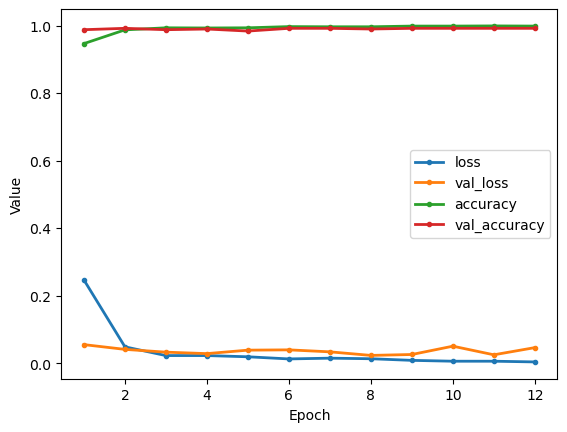

In [13]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [14]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k2, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=3</li></ul>
</h4>

In [15]:
k = 3
X, y, features_k3 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAA,AAC,AAD,AAE,AAF,AAG,AAH,AAI,AAK,AAL,...,YYN,YYP,YYQ,YYR,YYS,YYT,YYV,YYW,YYX,YYY
386,0.002967,0.0,0.0,0.001484,0.001484,0.001484,0.0,0.0,0.000000,0.002967,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2297,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
588,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.003731,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
394,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.003215,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2756,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.003333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (2459, 8672)
X_test: (615, 8672)
y_train: (2459,)
y_test: (615,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [17]:
name="FEEDFORWARD_k3"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 256)                 │       2,220,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,263,553 (8.63 MB)

 Trainable params: 2,263,553 (8.63 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/31 ━━━━━━━━━━━━━━━━━━━━ 14s 483ms/step - accuracy: 0.5781 - loss: 0.6931

 9/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5293 - loss: 0.6929   

18/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6186 - loss: 0.6900

27/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6837 - loss: 0.6839

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7100 - loss: 0.6782 - val_accuracy: 0.9939 - val_loss: 0.4661


Epoch 2/100


 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.4737

10/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.4165 

19/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9984 - loss: 0.3622

28/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9973 - loss: 0.3171

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9970 - loss: 0.3007 - val_accuracy: 0.9980 - val_loss: 0.0166


Epoch 3/100


 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.0113

10/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0109 

19/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9994 - loss: 0.0111

28/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9992 - loss: 0.0116

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9991 - loss: 0.0117 - val_accuracy: 0.9980 - val_loss: 0.0087


Epoch 4/100


 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.0033

10/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0030 

19/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9999 - loss: 0.0030

28/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9997 - loss: 0.0031

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9997 - loss: 0.0031 - val_accuracy: 0.9980 - val_loss: 0.0083


Epoch 5/100


 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.0013

10/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.9171e-04

19/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9998 - loss: 0.0015    

28/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9997 - loss: 0.0019

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9996 - loss: 0.0020 - val_accuracy: 0.9980 - val_loss: 0.0081


Epoch 6/100


 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.0011

10/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.7180e-04

19/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.5019e-04

28/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.2710e-04

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.1689e-04 - val_accuracy: 0.9980 - val_loss: 0.0106


Epoch 7/100


 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 2.8026e-04

10/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.7128e-04 

18/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.6647e-04

22/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.7224e-04

30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.7249e-04

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.7236e-04 - val_accuracy: 0.9980 - val_loss: 0.0121


Epoch 8/100


 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 2.1754e-04

 9/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.1842e-04 

11/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 2.1513e-04

15/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 2.0612e-04

21/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 1.9323e-04

29/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 1.8444e-04

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 1.8147e-04 - val_accuracy: 0.9980 - val_loss: 0.0124


Epoch 9/100


 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 5.3601e-05

 9/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.6706e-04 

18/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.8455e-04

26/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.0905e-04

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.1487e-04 - val_accuracy: 0.9980 - val_loss: 0.0093


Epoch 10/100


 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 1.2936e-04

10/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.3988e-04 

19/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.3600e-04

28/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.3070e-04

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.2876e-04 - val_accuracy: 0.9980 - val_loss: 0.0120


Epoch 11/100


 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 1.2013e-04

10/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 8.5744e-05 

19/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.0450e-05

28/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 8.8964e-05

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.8122e-05 - val_accuracy: 0.9980 - val_loss: 0.0125


Epoch 12/100


 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 1.0000 - loss: 5.2001e-05

 6/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 6.3807e-05

11/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 5.7554e-05

16/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 5.4102e-05

21/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 5.1778e-05

27/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 4.9805e-05

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 4.8817e-05 - val_accuracy: 0.9980 - val_loss: 0.0130



[Train Accuracy: 100.00% - Test Accuracy: 99.35%]


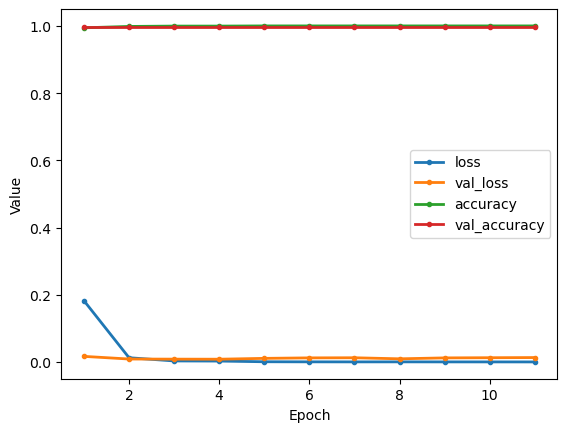

In [18]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [19]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k3, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=4</li></ul>
</h4>

In [20]:
k = 4
X, y, features_k4 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAAA,AAAC,AAAD,AAAE,AAAF,AAAG,AAAH,AAAI,AAAK,AAAL,...,YYYM,YYYN,YYYP,YYYQ,YYYR,YYYS,YYYT,YYYV,YYYX,YYYY
386,0.001486,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2297,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
588,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
394,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2756,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 2 : FEED-FORWARD NETWORKS</span>

In [22]:
name="FEEDFORWARD_k4"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                     │ (None, 256)                 │      32,712,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32,754,177 (124.95 MB)

 Trainable params: 32,754,177 (124.95 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/31 ━━━━━━━━━━━━━━━━━━━━ 19s 659ms/step - accuracy: 0.3906 - loss: 0.6932

 2/31 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.4102 - loss: 0.6932  

 3/31 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.4245 - loss: 0.6932

 4/31 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.4365 - loss: 0.6931

 5/31 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.4580 - loss: 0.6931

 6/31 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.4745 - loss: 0.6930

 7/31 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.4887 - loss: 0.6928

 8/31 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.5023 - loss: 0.6927

 9/31 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.5157 - loss: 0.6925

10/31 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.5290 - loss: 0.6923

11/31 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.5419 - loss: 0.6921

12/31 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.5531 - loss: 0.6919

13/31 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.5640 - loss: 0.6916

14/31 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.5742 - loss: 0.6913

15/31 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.5836 - loss: 0.6910

16/31 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.5924 - loss: 0.6907

17/31 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.6007 - loss: 0.6904

18/31 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.6086 - loss: 0.6900

19/31 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.6163 - loss: 0.6896

20/31 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.6237 - loss: 0.6892

21/31 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.6308 - loss: 0.6887

22/31 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.6376 - loss: 0.6882

23/31 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.6441 - loss: 0.6877

24/31 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.6503 - loss: 0.6871

25/31 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.6563 - loss: 0.6865

26/31 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.6621 - loss: 0.6858

27/31 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.6676 - loss: 0.6851

28/31 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.6730 - loss: 0.6843

29/31 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.6781 - loss: 0.6834

30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.6831 - loss: 0.6825

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.6878 - loss: 0.6815

31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 0.6923 - loss: 0.6806 - val_accuracy: 0.9634 - val_loss: 0.5161


Epoch 2/100


 1/31 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - accuracy: 0.9844 - loss: 0.5148

 2/31 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.9844 - loss: 0.5115

 3/31 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.9844 - loss: 0.5064

 4/31 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.9844 - loss: 0.5006

 5/31 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.9850 - loss: 0.4955

 6/31 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.9845 - loss: 0.4906

 7/31 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.9844 - loss: 0.4854

 8/31 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.9847 - loss: 0.4799

 9/31 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.9848 - loss: 0.4746

10/31 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.9846 - loss: 0.4694

11/31 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.9846 - loss: 0.4640

12/31 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.9846 - loss: 0.4587

13/31 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.9846 - loss: 0.4531

14/31 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.9843 - loss: 0.4478

15/31 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.9841 - loss: 0.4423

16/31 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.9839 - loss: 0.4368

17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9838 - loss: 0.4314

18/31 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9836 - loss: 0.4259

19/31 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9836 - loss: 0.4204

20/31 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9836 - loss: 0.4149

21/31 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9836 - loss: 0.4095

22/31 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9836 - loss: 0.4042

23/31 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9836 - loss: 0.3989

24/31 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9836 - loss: 0.3938

25/31 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9836 - loss: 0.3887

26/31 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9836 - loss: 0.3837

27/31 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9836 - loss: 0.3789

28/31 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9837 - loss: 0.3741

29/31 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9837 - loss: 0.3694

30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9837 - loss: 0.3649

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9838 - loss: 0.3604

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - accuracy: 0.9838 - loss: 0.3563 - val_accuracy: 0.9898 - val_loss: 0.0425


Epoch 3/100


 1/31 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.9844 - loss: 0.0374

 2/31 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.9883 - loss: 0.0322

 3/31 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.9887 - loss: 0.0312

 4/31 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.9896 - loss: 0.0300

 5/31 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.9898 - loss: 0.0291

 6/31 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.9902 - loss: 0.0280

 7/31 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.9903 - loss: 0.0274

 8/31 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.9906 - loss: 0.0266

 9/31 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.9908 - loss: 0.0259

10/31 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.9911 - loss: 0.0252

11/31 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.9914 - loss: 0.0246

12/31 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.9917 - loss: 0.0239

13/31 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.9920 - loss: 0.0234

14/31 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.9922 - loss: 0.0229

15/31 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.9925 - loss: 0.0224

16/31 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.9927 - loss: 0.0220

17/31 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.9929 - loss: 0.0215

18/31 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9931 - loss: 0.0211

19/31 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9933 - loss: 0.0207

20/31 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9935 - loss: 0.0203

21/31 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9936 - loss: 0.0200

22/31 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9938 - loss: 0.0196

23/31 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9939 - loss: 0.0193

24/31 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9940 - loss: 0.0190

25/31 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.9942 - loss: 0.0187

26/31 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.9942 - loss: 0.0185

27/31 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.9943 - loss: 0.0182

28/31 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.9944 - loss: 0.0180

29/31 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.9945 - loss: 0.0178

30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.9946 - loss: 0.0176

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9946 - loss: 0.0173

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - accuracy: 0.9947 - loss: 0.0171 - val_accuracy: 0.9959 - val_loss: 0.0187


Epoch 4/100


 1/31 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - accuracy: 1.0000 - loss: 0.0047

 2/31 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 0.0042

 3/31 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 0.0040

 4/31 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 0.0040

 5/31 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 0.0039

 6/31 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 0.0037

 7/31 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 0.0036

 8/31 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 0.0035

 9/31 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 0.0034

10/31 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 0.0033

11/31 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 0.0032

12/31 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 0.0031

13/31 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 0.0031

14/31 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 0.0030

15/31 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 0.0029

16/31 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 0.0029

17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 0.0029

18/31 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 0.0028

19/31 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 0.0028

20/31 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 0.0028

21/31 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 0.0027

22/31 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 0.0027

23/31 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 0.0027

24/31 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 0.0026

25/31 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 0.0026

26/31 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 0.0026

27/31 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 0.0026

28/31 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 0.0025

29/31 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 0.0025

30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 0.0025

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 0.0025

31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 1.0000 - loss: 0.0024 - val_accuracy: 0.9898 - val_loss: 0.0263


Epoch 5/100


 1/31 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - accuracy: 1.0000 - loss: 0.0012

 2/31 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 1.0000 - loss: 0.0011

 3/31 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 1.0000 - loss: 0.0012

 4/31 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 1.0000 - loss: 0.0012

 5/31 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 1.0000 - loss: 0.0012

 6/31 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 1.0000 - loss: 0.0012

 7/31 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 1.0000 - loss: 0.0012

 8/31 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 1.0000 - loss: 0.0011

 9/31 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 1.0000 - loss: 0.0011

10/31 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 1.0000 - loss: 0.0011

11/31 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 0.0011

12/31 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 0.0011

13/31 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 0.0011

14/31 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 0.0010

15/31 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 0.0010

16/31 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 0.0010

17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 0.0010

18/31 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 9.9280e-04

19/31 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 9.8180e-04

20/31 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 9.7146e-04

21/31 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 9.6169e-04

22/31 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 9.5185e-04

23/31 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 9.4247e-04

24/31 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 9.3325e-04

25/31 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 9.2504e-04

26/31 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 9.1698e-04

27/31 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 9.0932e-04

28/31 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 9.0184e-04

29/31 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 8.9448e-04

30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 8.8809e-04

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 8.8215e-04

31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 1.0000 - loss: 8.7659e-04 - val_accuracy: 0.9898 - val_loss: 0.0270


Epoch 6/100


 1/31 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 1.0000 - loss: 9.4634e-04

 2/31 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 9.5778e-04

 3/31 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 9.6759e-04

 4/31 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 9.8647e-04

 5/31 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 9.8658e-04

 6/31 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 9.8662e-04

 7/31 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 0.0010    

 8/31 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 0.0010

 9/31 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 0.0010

10/31 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 9.9439e-04

11/31 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 9.8543e-04

12/31 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 9.7812e-04

13/31 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 9.6862e-04

14/31 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 9.5877e-04

15/31 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 1.0000 - loss: 9.4764e-04

16/31 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 1.0000 - loss: 9.3575e-04

17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 9.2377e-04

18/31 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 9.1182e-04

19/31 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 8.9997e-04

20/31 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 8.8853e-04

21/31 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 8.7722e-04

22/31 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 8.6628e-04

23/31 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 8.7056e-04

24/31 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 8.7336e-04

25/31 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 8.7485e-04

26/31 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 8.7538e-04

27/31 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 8.7496e-04

28/31 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 8.7379e-04

29/31 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 8.7225e-04

30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 8.7033e-04

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 8.6815e-04

31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 1.0000 - loss: 8.6610e-04 - val_accuracy: 0.9939 - val_loss: 0.0194


Epoch 7/100


 1/31 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - accuracy: 1.0000 - loss: 2.3202e-04

 2/31 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 1.0000 - loss: 2.5660e-04

 3/31 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 1.0000 - loss: 2.8262e-04

 4/31 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 1.0000 - loss: 2.9452e-04

 5/31 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 1.0000 - loss: 3.0372e-04

 6/31 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 1.0000 - loss: 3.1109e-04

 7/31 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 1.0000 - loss: 3.1409e-04

 8/31 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 1.0000 - loss: 3.1905e-04

 9/31 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 1.0000 - loss: 3.2284e-04

10/31 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 1.0000 - loss: 3.2559e-04

11/31 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 1.0000 - loss: 3.2799e-04

12/31 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 1.0000 - loss: 3.2937e-04

13/31 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 1.0000 - loss: 3.3387e-04

14/31 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 1.0000 - loss: 3.3689e-04

15/31 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 1.0000 - loss: 3.3917e-04

16/31 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 1.0000 - loss: 3.4112e-04

17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 3.4213e-04

18/31 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 3.4420e-04

19/31 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 3.4563e-04

20/31 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 3.4648e-04

21/31 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 3.4731e-04

22/31 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 3.4813e-04

23/31 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 3.4915e-04

24/31 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 3.4981e-04

25/31 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 3.5034e-04

26/31 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 3.5049e-04

27/31 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 3.5054e-04

28/31 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 3.5049e-04

29/31 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 3.5022e-04

30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 3.4971e-04

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 3.4906e-04

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - accuracy: 1.0000 - loss: 3.4844e-04 - val_accuracy: 0.9898 - val_loss: 0.0275


Epoch 8/100


 1/31 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - accuracy: 1.0000 - loss: 1.9118e-04

 2/31 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 2.0159e-04

 3/31 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 1.0000 - loss: 2.0242e-04

 4/31 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 1.0000 - loss: 2.2896e-04

 5/31 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 1.0000 - loss: 2.3754e-04

 6/31 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 2.5255e-04

 7/31 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 2.6090e-04

 8/31 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 2.6562e-04

 9/31 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 1.0000 - loss: 2.6790e-04

10/31 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 2.7203e-04

11/31 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 2.7607e-04

12/31 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 2.7930e-04

13/31 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 2.8098e-04

14/31 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 1.0000 - loss: 2.8174e-04

15/31 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 1.0000 - loss: 2.8193e-04

16/31 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 1.0000 - loss: 2.8158e-04

17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 2.8105e-04

18/31 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 2.8035e-04

19/31 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 2.7935e-04

20/31 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 2.7842e-04

21/31 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 2.7761e-04

22/31 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 2.7657e-04

23/31 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 2.7529e-04

24/31 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 2.7387e-04

25/31 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 2.7235e-04

26/31 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 2.7078e-04

27/31 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 2.6925e-04

28/31 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 2.6766e-04

29/31 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 2.6609e-04

30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 2.6500e-04

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 2.6396e-04

31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 1.0000 - loss: 2.6298e-04 - val_accuracy: 0.9898 - val_loss: 0.0282


Epoch 9/100


 1/31 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - accuracy: 1.0000 - loss: 1.5257e-04

 2/31 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 1.4185e-04

 3/31 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 1.3994e-04

 4/31 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 1.4058e-04

 5/31 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 1.3893e-04

 6/31 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 1.4501e-04

 7/31 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 1.0000 - loss: 1.4888e-04

 8/31 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 1.0000 - loss: 1.5098e-04

 9/31 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 1.0000 - loss: 1.5280e-04

10/31 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 1.0000 - loss: 1.5356e-04

11/31 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 1.0000 - loss: 1.5370e-04

12/31 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 1.0000 - loss: 1.5334e-04

13/31 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 1.0000 - loss: 1.5292e-04

14/31 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 1.0000 - loss: 1.5247e-04

15/31 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 1.0000 - loss: 1.5171e-04

16/31 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 1.0000 - loss: 1.5122e-04

17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 1.5098e-04

18/31 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 1.5053e-04

19/31 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 1.4996e-04

20/31 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 1.4930e-04

21/31 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 1.4857e-04

22/31 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 1.4793e-04

23/31 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 1.4718e-04

24/31 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 1.4644e-04

25/31 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 1.4565e-04

26/31 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 1.4486e-04

27/31 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 1.4413e-04

28/31 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 1.4345e-04

29/31 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 1.4309e-04

30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 1.4268e-04

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 1.4227e-04

31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 1.0000 - loss: 1.4189e-04 - val_accuracy: 0.9898 - val_loss: 0.0306


Epoch 10/100


 1/31 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - accuracy: 1.0000 - loss: 2.2820e-04

 2/31 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 1.8178e-04

 3/31 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 1.5602e-04

 4/31 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 1.4464e-04

 5/31 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 1.0000 - loss: 1.3732e-04

 6/31 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 1.0000 - loss: 1.3347e-04

 7/31 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 1.0000 - loss: 1.2924e-04

 8/31 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 1.2558e-04

 9/31 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 1.2261e-04

10/31 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 1.2303e-04

11/31 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 1.0000 - loss: 1.2292e-04

12/31 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 1.0000 - loss: 1.2271e-04

13/31 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 1.0000 - loss: 1.2255e-04

14/31 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 1.0000 - loss: 1.2219e-04

15/31 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 1.0000 - loss: 1.2171e-04

16/31 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 1.0000 - loss: 1.2242e-04

17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 1.2288e-04

18/31 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 1.2308e-04

19/31 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 1.2345e-04

20/31 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 1.2375e-04

21/31 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 1.2398e-04

22/31 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 1.2516e-04

23/31 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 1.2630e-04

24/31 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 1.2725e-04

25/31 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 1.2804e-04

26/31 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 1.2907e-04

27/31 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 1.2998e-04

28/31 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 1.3068e-04

29/31 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 1.3129e-04

30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 1.3178e-04

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 1.3221e-04

31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 1.0000 - loss: 1.3261e-04 - val_accuracy: 0.9898 - val_loss: 0.0298


Epoch 11/100


 1/31 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - accuracy: 1.0000 - loss: 8.1942e-05

 2/31 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 8.0498e-05

 3/31 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 8.9171e-05

 4/31 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 8.9042e-05

 5/31 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 8.6891e-05

 6/31 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 8.4557e-05

 7/31 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 8.2269e-05

 8/31 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 8.0449e-05

 9/31 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 7.9211e-05

10/31 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 7.8032e-05

11/31 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 7.6948e-05

12/31 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 7.5809e-05

13/31 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 7.5030e-05

14/31 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 7.4244e-05

15/31 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 7.3458e-05

16/31 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 7.2786e-05

17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 7.2482e-05

18/31 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 7.2067e-05

19/31 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 7.1689e-05

20/31 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 7.1261e-05

21/31 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 7.0889e-05

22/31 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 7.0712e-05

23/31 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 7.0493e-05

24/31 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 7.0220e-05

25/31 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 6.9961e-05

26/31 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 6.9728e-05

27/31 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 6.9659e-05

28/31 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 6.9581e-05

29/31 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 6.9480e-05

30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 6.9424e-05

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 6.9371e-05

31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 1.0000 - loss: 6.9321e-05 - val_accuracy: 0.9898 - val_loss: 0.0321


Epoch 12/100


 1/31 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 1.0000 - loss: 2.7965e-05

 2/31 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 2.7804e-05

 3/31 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 1.0000 - loss: 2.8679e-05

 4/31 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 1.0000 - loss: 3.3847e-05

 5/31 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 1.0000 - loss: 3.6081e-05

 6/31 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 3.9266e-05

 7/31 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 4.1687e-05

 8/31 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 4.3481e-05

 9/31 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 4.4726e-05

10/31 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 4.5999e-05

11/31 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 4.7052e-05

12/31 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 4.7783e-05

13/31 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 4.8182e-05

14/31 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 4.8395e-05

15/31 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 4.8533e-05

16/31 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 4.8732e-05

17/31 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 4.8821e-05

18/31 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 4.8864e-05

19/31 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 4.8843e-05

20/31 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 4.8809e-05

21/31 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 4.8778e-05

22/31 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 4.8754e-05

23/31 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 4.8741e-05

24/31 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 4.8738e-05

25/31 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 4.8694e-05

26/31 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 4.8645e-05

27/31 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 4.8577e-05

28/31 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 4.8482e-05

29/31 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 4.8446e-05

30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 4.8396e-05

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 4.8419e-05

31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 1.0000 - loss: 4.8440e-05 - val_accuracy: 0.9898 - val_loss: 0.0342


Epoch 13/100


 1/31 ━━━━━━━━━━━━━━━━━━━━ 7s 261ms/step - accuracy: 1.0000 - loss: 4.7368e-05

 2/31 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - accuracy: 1.0000 - loss: 4.1580e-05

 3/31 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - accuracy: 1.0000 - loss: 3.9525e-05 

 4/31 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 1.0000 - loss: 3.8170e-05

 5/31 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 1.0000 - loss: 3.6915e-05

 6/31 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 1.0000 - loss: 3.7353e-05

 7/31 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 1.0000 - loss: 3.7450e-05

 8/31 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 3.7406e-05

 9/31 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 3.7331e-05

10/31 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 3.7194e-05

11/31 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 3.7108e-05

12/31 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 3.7618e-05

13/31 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 3.8051e-05

14/31 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 3.8299e-05

15/31 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 3.8422e-05

16/31 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 3.8422e-05

17/31 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 1.0000 - loss: 3.8451e-05

18/31 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 3.8485e-05

19/31 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 3.8540e-05

20/31 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 3.8629e-05

21/31 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 3.8896e-05

22/31 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 3.9148e-05

23/31 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 3.9543e-05

24/31 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 3.9875e-05

25/31 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 4.0271e-05

26/31 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 4.0616e-05

27/31 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 4.0960e-05

28/31 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 4.1279e-05

29/31 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 4.1553e-05

30/31 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 4.1779e-05

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 4.1980e-05

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - accuracy: 1.0000 - loss: 4.2169e-05 - val_accuracy: 0.9898 - val_loss: 0.0334



[Train Accuracy: 100.00% - Test Accuracy: 99.19%]


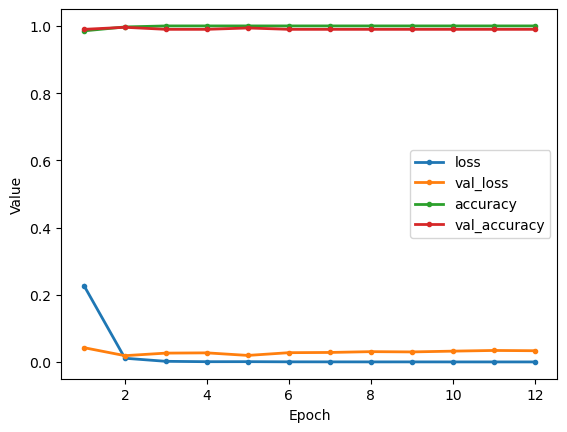

In [23]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [24]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k4, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step

 7/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 

13/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


 1/20 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

 7/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 

13/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


In [25]:
report.save()

Report saved as Output/Reports/BES1/report_971QVR7F.html


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=5</li></ul>
</h4>

In [26]:
"""k = 5
X, y, features_k5 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()"""

"k = 5\nX, y, features_k5 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)\nX_test.head()"

In [27]:
"""NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]"""

'NUM_CLASS  = 1\nSEQ_LENGTH = X_train.shape[1]'

* <span style="color: blue; font-weight: bold;">MODEL 3 : FEED-FORWARD NETWORKS</span>

In [28]:
"""name="FEEDFORWARD_k5"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(2*256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))"""

'name="FEEDFORWARD_k5"\ndef feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):\n    model = Sequential(name=name)\n    model.add(Input(shape=(SEQ_LENGTH,)))\n    model.add(Dense(2*256, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(128, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(64, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(num_output, activation=\'sigmoid\'))\n    model.compile(loss=\'binary_crossentropy\', optimizer=\'adam\', metrics=[\'accuracy\'])\n    model.summary()\n    return model\n\n# Build & train the model\nmodel = feedforward_net1()\nstop_callback = early_stopping(patience=10)\nsave_callback = model_checkpoint(name)\n\nX_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)\nhistory = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])\n\n# Evaluate and sc

In [29]:
"""VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])"""

"VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])"

In [30]:
"""VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k5, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])
report.save('end')"""

'VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k5, len(dataset)]) \nreport.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])\nreport.save(\'end\')'

In [31]:
# END

In [32]:
######################################### DEBUG TO OPTIMIZE K-MER LOEADER FUNCTION ###########################################